* Spearmint for analogy reasoning
* Gaussian LDA
* Evaluate word analogy reasoning
* evalutate topic models
* find background noise
* find word pairs

# Setup

In [1]:
%matplotlib notebook

import itertools
from functools import partial
import numpy as np
import gensim, logging
import pandas as pnd
from sklearn.cluster import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, RandomizedPCA
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
div.text_cell_render p, div.text_cell_render ul, table.dataframe {
font-size:1.3em;
line-height:1.1em;
}
</style>
""")

In [3]:
MODEL = "../models/topic-models/topic.full.alpha-1-100.256-400.model"

# Evaluating strength of raw models

## Topic Models → Topic Coherence, Concept Categorization

Evaluated using Palmetto tool from **Exploring the Space of Topic Coherence Measures** paper
Values still seem low compared to example values from the paper

In [4]:
df_tc_results = pnd.DataFrame([
        ("topic.full.alpha-1-100.256-400.model", 0.469500859375, 0.00617111859067, 0.6463414634146342),
        ("topic.16-400.model", 0.43805875, 0.00390183951094, 0.5975609756097561),
        ("topic.256-1000.model", 0.473455351563, 0.00635883046394, 0.5853658536585366),
        ("topic.64-400.model", 0.45327734375, 0.00385141007263, 0.6341463414634146),
        ("topic.256-400.model", 0.46836359375, 0.00599032492068, 0.5731707317073171),
        ("topic.full.fixed-vocabulary.alpha-1-100.256-400.model", 0.468437070312, 0.00562772603243, 0.5975609756097561),
        ("topic.full.256-400.model", 0.472498945313, 0.00624853749772, 0.5975609756097561),
        ("topic.256-600.model", 0.478640273437, 0.00685787139094, 0.5609756097560975)
    ], 
    columns=["Topic model parameters", "TC_mean", "TC_var", "CC_purity"])

In [5]:
df_tc_results.sort_values(by="TC_mean", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
7,topic.256-600.model,0.478640,0.006858,0.560976
2,topic.256-1000.model,0.473455,0.006359,0.585366
6,topic.full.256-400.model,0.472499,0.006249,0.597561
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
5,topic.full.fixed-vocabulary.alpha-1-100.256-40...,0.468437,0.005628,0.597561
4,topic.256-400.model,0.468364,0.005990,0.573171
3,topic.64-400.model,0.453277,0.003851,0.634146
1,topic.16-400.model,0.438059,0.003902,0.597561


In [6]:
df_tc_results.sort_values(by="CC_purity", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
3,topic.64-400.model,0.453277,0.003851,0.634146
1,topic.16-400.model,0.438059,0.003902,0.597561
5,topic.full.fixed-vocabulary.alpha-1-100.256-40...,0.468437,0.005628,0.597561
6,topic.full.256-400.model,0.472499,0.006249,0.597561
2,topic.256-1000.model,0.473455,0.006359,0.585366
4,topic.256-400.model,0.468364,0.005990,0.573171
7,topic.256-600.model,0.478640,0.006858,0.560976


## Word Embeddings → Analogy Reasoning

Using the question word data set (~19k questions) from **Efficient Estimation of Word Representations in Vector Space** (word2vec).
Also, currently running Spearmint optimization to look for better embeddings.

In [7]:
pnd.set_option("display.max_colwidth", 100)

In [35]:
df_tc_results = pnd.DataFrame([
        ("embedding.skip-gram.size-200.window-5.negative-5.model", 0.481221858371),
        ("embedding.cbow.size-200.window-5.model", 0.416547277937),
        ("embedding.google.size-300", 0.735878018829),
    ], 
    columns=["Word Embeddings", "Analogy_Reasoning"])

df_tc_results.sort_values(by="Analogy_Reasoning", ascending=False)

,Word Embeddings,Analogy_Reasoning
2,embedding.google.size-300,0.735878
0,embedding.skip-gram.size-200.window-5.negative-5.model,0.481222
1,embedding.cbow.size-200.window-5.model,0.416547


# Preprocessing

## Word Embeddings

In [9]:
SKIP_GRAM_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/embedding.model.skip-gram"
WORD2VEC_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/GoogleNews-vectors-negative300.bin"

vectors = gensim.models.Word2Vec.load_word2vec_format(SKIP_GRAM_VECTOR_FILE, binary=True)
#vectors = gensim.models.Word2Vec.load_word2vec_format(WORD2VEC_VECTOR_FILE, binary=True)


## Topic Probs

In [10]:
prob_columns = list(range(256))
df_probs = pnd.read_csv(MODEL + ".topic-probs")
df_probs.head(1)

,word,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,telenovela,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09


In [11]:
#avg = df_probs.ix[:,1:-2].sum(axis=1)

In [12]:
#df_probs.ix[:,1:-2] = df_probs.ix[:,1:-2] / avg

In [13]:
df_probs

,word,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,telenovela,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09
1,series,2.235823e-04,3.315042e-04,4.121432e-09,1.977594e-03,7.010474e-08,1.989654e-04,1.712372e-09,1.493256e-03,2.901264e-09,...,4.833850e-05,2.033049e-09,1.536688e-04,1.029281e-04,3.913604e-09,3.447599e-09,1.398627e-03,6.396890e-05,3.104720e-09,1.171903e-03
2,american,1.316723e-09,1.981514e-09,3.276367e-03,5.543581e-03,4.728217e-10,3.481988e-09,3.924866e-02,9.669474e-04,2.901264e-09,...,6.514222e-04,2.033049e-09,2.443655e-09,1.878764e-09,6.097844e-04,3.447599e-09,1.489039e-09,2.079543e-04,3.104720e-09,8.630787e-04
3,single-camera,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09
4,sitcom,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09
5,television,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,1.125110e-03,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.466611e-05,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,4.659187e-04
6,starring,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.142226e-05
7,eva,1.316723e-09,1.981514e-09,4.121432e-09,7.564329e-06,1.444867e-04,3.481988e-09,1.034106e-05,3.596627e-06,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,8.204402e-05
8,longoria,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09
9,jencarlos,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09


In [14]:
#df_probs.head(1).ix[:,1:-2].sum(axis=1)

## Topics

In [15]:
df_topics = pnd.read_csv(MODEL + ".ssv", sep=" ", encoding="utf-8")
topic_words = set(df_topics.ix[:,-10:].values.flatten())
df_topics.head(10)

,topic,topic-count,0,1,2,3,4,5,6,7,8,9
0,91,19110157,would,time,new,first,however,years,could,later,one,made
1,4,14358862,family,life,years,born,died,father,later,became,married,first
2,191,9752986,may,time,often,many,one,however,used,would,number,also
3,211,8215111,people,many,century,population,groups,also,culture,language,ethnic,community
4,126,7605393,one,said,like,life,man,people,wrote,time,would,even
5,160,7577692,would,death,one,found,two,later,time,said,could,day
6,237,7197569,university,served,born,president,school,member,career,director,degree,also
7,205,6912691,village,town,area,population,district,located,local,parish,road,church
8,15,6881515,war,military,government,army,forces,troops,general,political,would,led
9,206,6746498,would,said,time,one,later,stated,could,new,like,people


## Similars

In [16]:
def get_similarity(word1, word2, v):
    # ugly but works for now
    if word1 not in v:
        if word1.upper() in v:
            word1 = word1.upper()
        if word1.title() in v:
            word1 = word1.title()
    if word2 not in v:
        if word2.upper() in v:
            word2 = word2.upper()
        if word2.title() in v:
            word2 = word2.title()
    try:
        return v.similarity(word1, word2)
    except KeyError:         
        return -1.0

df_similars = pnd.read_csv(MODEL + ".similars", sep="\t", header=None, encoding="utf-8")
df_similars["tm_sim"] = 1 - (df_similars[0] / 2)
del df_similars[0]
del df_similars[1]
df_similars.columns = ["word", "similars", "tm_sim"]
df_similars["we_sim"] = df_similars[["word", "similars"]].apply(
    lambda x: get_similarity(x["word"], x["similars"], vectors), axis=1)
df_similars = df_similars[df_similars["word"] != df_similars["similars"]]
df_similars = df_similars[df_similars["we_sim"] != -1]

# Analysis

## Topic Probs

In [42]:
df_probs["mean"] = df_probs[prob_columns].mean(axis=1)
df_probs["stddev"] = df_probs[prob_columns].std(axis=1)
df_probs = df_probs[df_probs.word.apply(lambda w: w in topic_words)]

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [43]:
df_probs

,word,0,1,2,3,4,5,6,7,8,...,248,249,250,251,252,253,254,255,mean,stddev
1,series,2.235823e-04,3.315042e-04,4.121432e-09,1.977594e-03,7.010474e-08,1.989654e-04,1.712372e-09,1.493256e-03,2.901264e-09,...,1.536688e-04,1.029281e-04,3.913604e-09,3.447599e-09,1.398627e-03,6.396890e-05,3.104720e-09,1.171903e-03,0.001211,0.004617
2,american,1.316723e-09,1.981514e-09,3.276367e-03,5.543581e-03,4.728217e-10,3.481988e-09,3.924866e-02,9.669474e-04,2.901264e-09,...,2.443655e-09,1.878764e-09,6.097844e-04,3.447599e-09,1.489039e-09,2.079543e-04,3.104720e-09,8.630787e-04,0.001467,0.003688
5,television,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,1.125110e-03,2.901264e-09,...,2.443655e-09,1.466611e-05,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,4.659187e-04,0.000423,0.002214
6,starring,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.142226e-05,0.000097,0.000609
14,spanish,1.316723e-09,1.079915e-05,4.691832e-04,3.249190e-04,4.728217e-10,7.487060e-05,1.712372e-09,1.078398e-04,2.901264e-09,...,2.443655e-09,1.878764e-09,3.913604e-09,2.542068e-06,1.489039e-09,3.115911e-05,3.104720e-09,3.939127e-05,0.000417,0.002971
15,soap,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,1.260385e-05,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09,0.000033,0.000266
16,opera,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,3.210079e-05,8.720887e-06,5.060707e-07,6.011328e-07,2.901264e-09,...,2.443655e-09,1.142722e-04,3.913604e-09,5.588412e-06,1.489039e-09,1.602794e-09,3.104720e-09,2.009224e-02,0.000053,0.000437
19,florida,1.316723e-09,1.981514e-09,4.121432e-09,1.431656e-05,4.728217e-10,3.481988e-09,1.276280e-03,6.044927e-04,2.901264e-09,...,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,5.828460e-06,0.000278,0.002643
21,daily,5.526634e-05,1.581933e-03,4.121432e-09,7.294240e-06,1.622428e-04,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,7.485631e-05,4.676139e-05,3.913604e-09,2.294947e-04,1.489039e-09,4.225307e-05,3.104720e-09,1.771529e-05,0.000161,0.000838
22,life,1.078154e-03,1.981514e-09,4.121432e-09,2.663351e-03,1.838443e-02,7.128108e-05,7.837745e-04,1.857227e-04,2.901264e-09,...,3.141727e-04,7.110954e-05,3.913604e-09,1.507975e-04,1.489039e-09,1.602794e-09,3.104720e-09,1.056298e-03,0.000806,0.001758


### Highest mean

**Use these words for filtering, to avoid very generic topics?**

In [18]:
df_probs.sort_values(by="mean", ascending=False).head(10)[["word", "mean"]]

,word,mean
188,also,0.004890
430,first,0.004132
797,new,0.003872
169,one,0.003562
302,two,0.002967
35,may,0.002070
279,school,0.001927
546,city,0.001817
414,world,0.001808
483,time,0.001788


### Lowest mean

In [19]:
df_probs.sort_values(by="mean", ascending=True).head(10)[["word", "mean"]]

,word,mean
1193,symphony,0.000014
17527,superman,0.000025
28544,voltage,0.000025
6848,cuisine,0.000025
44949,nerve,0.000027
16897,dundee,0.000027
6849,cooking,0.000029
15956,byzantine,0.000029
13717,genes,0.000029
29709,kuala,0.000030


### Highest std. dev.

In [20]:
df_probs.sort_values(by="stddev", ascending=False).head(10)[["word", "stddev"]]

,word,stddev
797,new,0.013168
279,school,0.011742
699,film,0.009937
4859,station,0.008415
1161,york,0.008400
472,district,0.007070
297,university,0.006586
5365,population,0.006052
1043,county,0.005956
2151,age,0.005936


### Lowest std. dev.

In [21]:
df_probs.sort_values(by="stddev", ascending=True).head(10)[["word", "stddev"]]

,word,stddev
1193,symphony,0.000156
1194,orchestra,0.000250
15,soap,0.000266
15956,byzantine,0.000275
7024,evil,0.000297
16307,tissue,0.000309
17527,superman,0.000310
12521,extinct,0.000318
1199,jacques,0.000320
9586,organic,0.000322


## Correlation TM similarity and WE similarity

### Ten most similar words for each top-10-topic word

 Topic model similarity evaluated using [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence)
 This also encodes word probability. Normalize to one to get only topic proportions?

In [22]:
df_similars

,word,similars,tm_sim,we_sim
0,development,developed,0.980259,0.360895
1,development,project,0.971471,0.504817
2,development,develop,0.971291,0.439881
3,development,provide,0.970345,0.241174
4,development,developing,0.969815,0.601677
5,development,projects,0.969755,0.516865
6,development,environment,0.968790,0.501580
7,development,resources,0.968045,0.433210
8,development,management,0.967487,0.585662
9,development,provides,0.967271,0.285024


### Correlation between TM and WE similarity

In [23]:
df_similars[["tm_sim", "we_sim"]].corr("pearson")

,tm_sim,we_sim
tm_sim,1.000000,0.491426
we_sim,0.491426,1.000000


**Note: With google vectors, the correlation was only 0.21**

### Distribution of TM similarity

<IPython.core.display.Javascript object>


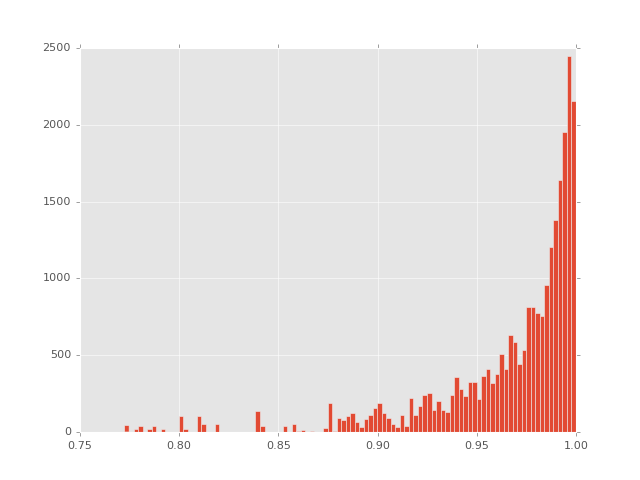

In [24]:
plt.figure()
df_similars["tm_sim"].hist(bins=100)

### Distribution of WE similarity

<IPython.core.display.Javascript object>


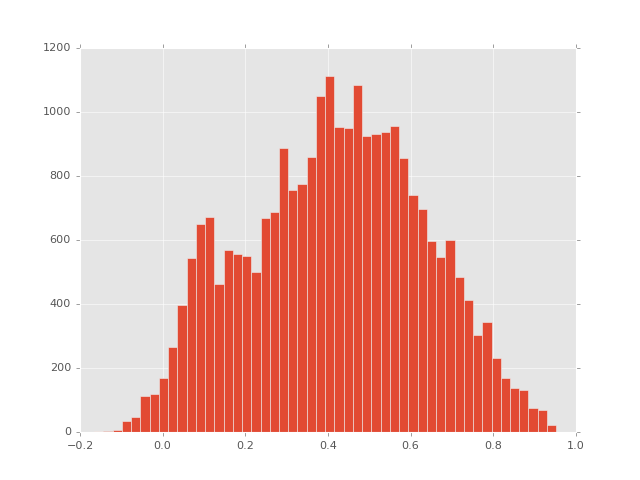

In [25]:
plt.figure()
df_similars["we_sim"].hist(bins=50)

In [26]:
we_percentile = df_similars["we_sim"].quantile(q=.30)
we_percentile

0.29805155008138051

In [27]:
df_tmp = df_probs[["word", "mean"]]
df_tmp.columns = ["w", "mean"]
df_result = df_similars.merge(df_tmp, left_on="similars", right_on="w")
del df_result["w"]
word_prob_quantile = df_result["mean"].quantile(0.8)

### High TM similarity, low WE similarity

In [28]:
df_large_sim_diff = df_result[(df_result["we_sim"] < 0.4) & (df_result["mean"] < word_prob_quantile)]
df_large_sim_diff.iloc[np.random.permutation(len(df_large_sim_diff))]

,word,similars,tm_sim,we_sim,mean
7581,species,snail,0.952136,0.398193,0.000038
9004,age,female,0.948928,0.123416,0.000324
840,united,washington,0.903314,0.147751,0.000320
7344,football,stadium,0.966976,0.351188,0.000204
8848,english,oxford,0.960740,0.314971,0.000092
469,system,available,0.953667,0.148010,0.000370
5668,artist,exhibition,0.985498,0.348175,0.000110
59,community,foundation,0.961077,0.357074,0.000212
1127,university,education,0.909449,0.268119,0.000566
7823,stadium,clubs,0.991041,0.188615,0.000143


### High TM similarity, high WE similarity

In [29]:
df_small_sim_diff = df_result[(df_result["we_sim"] > 0.8) & (df_result["mean"] < word_prob_quantile)]
df_small_sim_diff.iloc[np.random.permutation(len(df_small_sim_diff))]

,word,similars,tm_sim,we_sim,mean
7892,wellington,auckland,0.999023,0.816347,0.000064
9391,indonesia,malaysia,0.999440,0.868753,0.000132
8628,argentina,chile,0.998966,0.824045,0.000080
8267,billboard,chart,0.997042,0.802137,0.000161
1724,father,mother,0.991853,0.829030,0.000205
7771,award,awards,0.994718,0.833322,0.000433
9265,cell,cells,0.997523,0.816936,0.000116
423,locomotives,locomotive,0.999777,0.844325,0.000070
7130,election,elections,0.986822,0.889273,0.000162
6180,john,william,0.978145,0.832675,0.000431


# Findings

* syntatic variations play a bigger role in WE models, example:

  **(development, developed)**: TM-sim: 0.960519 WE-SIM: 0.360895
  
  **(composed, composers)** TM-SIM: 0.973376 WE-SIM: 0.329483
  
  **(works, working)** TM-SIM: 0.969470 WE-SIM: 0.274090
* topic models are better at capturing loose relationships, such as:

  **(war, commander)** TM-SIM: 0.922352 WE-SIM: 0.187498
  
  **(living, households)** TM-SIM: 0.983162 WE-SIM: 0.207906
  
  **(county, rural)** TM-SIM: 0.882099 WE-SIM: 0.257984
  